In [1]:
import networkx as nx
import pulp

# Data

In [3]:
G=nx.DiGraph()
G.add_edge("A","B",cost=120)
G.add_edge("B","D",cost=150)
G.add_edge("D","C",cost=120)
G.add_edge("C","D",cost=120)
G.add_edge("I","C",cost=250)
G.add_edge("D","I",cost=300)
G.add_edge("C","A",cost=150)
G.add_edge("D","E",cost=150)
G.add_edge("E","K",cost=250)
G.add_edge("K","J",cost=80)
G.add_edge("J","D",cost=250)
G.add_edge("J","I",cost=120)
G.add_edge("I","J",cost=120)
G.add_edge("K","L",cost=150)
G.add_edge("L","K",cost=150)
G.add_edge("L","M",cost=100)
G.add_edge("M","G",cost=250)
G.add_edge("G","N",cost=180)
G.add_edge("N","E",cost=260)
G.add_edge("E","F",cost=80)
G.add_edge("F","L",cost=250)
G.add_edge("F","G",cost=100)
G.add_edge("G","F",cost=100)

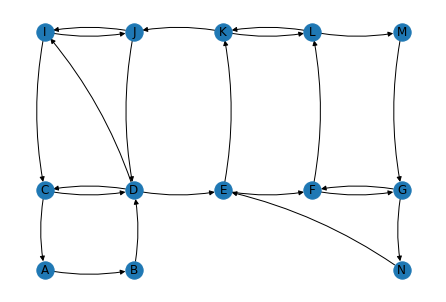

In [4]:
pos = {"A": (0, 0), "B": (1, 0), "D": (1, 1), "C": (0, 1), "I": (0, 3), "E": (2, 1), "K": (
    2, 3), "J": (1, 3), "L": (3, 3), "M": (4, 3), "N": (4, 0), "G": (4, 1), "F": (3, 1)}
nx.draw(G,
        with_labels=True,
        pos=pos,
        connectionstyle='arc3, rad = 0.1',
        )

# Compute cycles

In [124]:
for c in nx.simple_cycles(G):
    print(c)

['M', 'G', 'F', 'L']
['M', 'G', 'N', 'E', 'F', 'L']
['M', 'G', 'N', 'E', 'K', 'L']
['K', 'L']
['K', 'J', 'I', 'C', 'A', 'B', 'D', 'E', 'F', 'L']
['K', 'J', 'I', 'C', 'A', 'B', 'D', 'E']
['K', 'J', 'I', 'C', 'D', 'E', 'F', 'L']
['K', 'J', 'I', 'C', 'D', 'E']
['K', 'J', 'D', 'E', 'F', 'L']
['K', 'J', 'D', 'E']
['D', 'I', 'J']
['D', 'I', 'C', 'A', 'B']
['D', 'I', 'C']
['D', 'C', 'A', 'B']
['D', 'C']
['I', 'J']
['E', 'F', 'G', 'N']
['G', 'F']


The following code could definitely be optimized (many cycles are defined multiple times).

In [6]:
cycles = list(nx.simple_cycles(G))
G_cycles = {}
i = 1
# simple cycles
cycles_1 = []
for c in list(cycles):
    H = nx.DiGraph()
    nx.add_path(H, c)
    H.add_edge(c[-1], c[0])
    cost = sum(G[u][v]["cost"] for (u, v) in H.edges())
    H.graph["cost"] = cost
    G_cycles[i] = H
    cycles_1.append(H)
    i += 1
# 2-cycles
cycles_2 = []
for c1 in cycles:
    for c2 in cycles:
        if c1 != c2:
            H1 = nx.DiGraph()
            nx.add_path(H1, c1)
            H1.add_edge(c1[-1], c1[0])
            H2 = nx.DiGraph()
            nx.add_path(H2, c2)
            H2.add_edge(c2[-1], c2[0])
            if len(nx.intersection(H1, H2).nodes()) > 0:
                H = nx.compose(H1, H2)
                cost = sum(G[u][v]["cost"] for (u, v) in H.edges())
                H.graph["cost"] = cost
                G_cycles[i] = H
                cycles_2.append(H)
                i += 1
# 3-cycles
cycles_3 = []
for H1 in cycles_1:
    for H2 in cycles_2:
        if len(nx.intersection(H1, H2).nodes()) > 0:
            H = nx.compose(H1, H2)
            cost = sum(G[u][v]["cost"] for (u, v) in H.edges())
            H.graph["cost"] = cost
            G_cycles[i] = H
            cycles_3.append(H)
            i += 1

# MIP

In [7]:
# define problem
prob = pulp.LpProblem("cycles", pulp.LpMinimize)

# define variables
x = pulp.LpVariable.dicts("x", G_cycles.keys(), cat=pulp.LpBinary)
z = pulp.LpVariable("z", cat=pulp.LpContinuous, lowBound=0)

# objective function
prob += z

# cover each edge exactly once
for (i, j) in G.edges():
    prob += pulp.lpSum(x[g]
                       for g in x if (i, j) in G_cycles[g].edges()) == 1
# use exactly 3 cycles
prob += pulp.lpSum(x) == 3

# minimize z
for g in x:
    prob += G_cycles[g].graph["cost"]*x[g] <= z

In [10]:
# print problem for debug
#prob

In [11]:
# solve with default CBC solver
prob.solve()

1

In [15]:
prob.objective.value()

1320.0

In [13]:
# save solution
k = 1
for g in G_cycles:
    val = pulp.value(x[g])
    if val > 0.9:
        for (i, j) in G.edges():
            if (i, j) in G_cycles[g].edges():
                G[i][j]["cycle"] = k
        k += 1

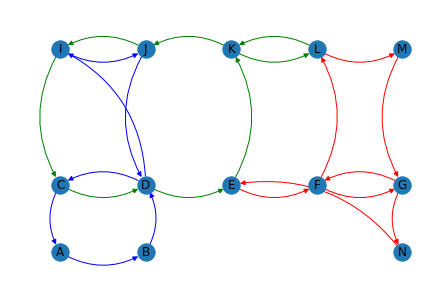

In [14]:
# plot solution
color = dict(zip([1,2,3],["blue","red","green"]))
nx.draw(G,
        with_labels=True,
        pos=pos,
        connectionstyle='arc3, rad = 0.3',
        edge_color=[color[G[u][v]["cycle"]] for (u, v) in G.edges()]
        )